In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import plotly.express as px


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# from sklearn.metrics import  mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # Random Forest Model
from xgboost.sklearn import XGBRegressor # XGBoost Model
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score # For cross validation
from math import sqrt

import seaborn as sns

/Users/kyra/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/Competition_Data.csv')
df.head()

,DateTime,Date,Hour,Temperature,Load
0,1/1/2008 1:00,1/1/2008,1,25.0,10737.0
1,1/1/2008 2:00,1/1/2008,2,24.0,10348.0
2,1/1/2008 3:00,1/1/2008,3,23.0,9997.0
3,1/1/2008 4:00,1/1/2008,4,23.0,9760.0
4,1/1/2008 5:00,1/1/2008,5,23.0,9624.0


Load will be closely related with the temperature. <br>
Load will have seasonality (Month, Time). We will use those variables to train our models. <br>
23:00 and 0:00 should have similar load but apart too much. -> We will use trigonometric measure to solve this issue # We can show this. <br>

In [3]:
# Make some variables for Machine Learning model training

df['DateTime'] = pd.to_datetime(df['DateTime'])
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['week'] = df['DateTime'].dt.week
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['weekofyear'] = df['DateTime'].dt.weekofyear

df['sin_time'] = np.sin(2*np.pi*df.Hour/24)
df['cos_time'] = np.cos(2*np.pi*df.Hour/24)
df.set_index('DateTime', inplace=True)

<ipython-input-3-0648aa034c25>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
<ipython-input-3-0648aa034c25>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


In [4]:
df1= df.loc['2008-01-01':'2008-01-03']

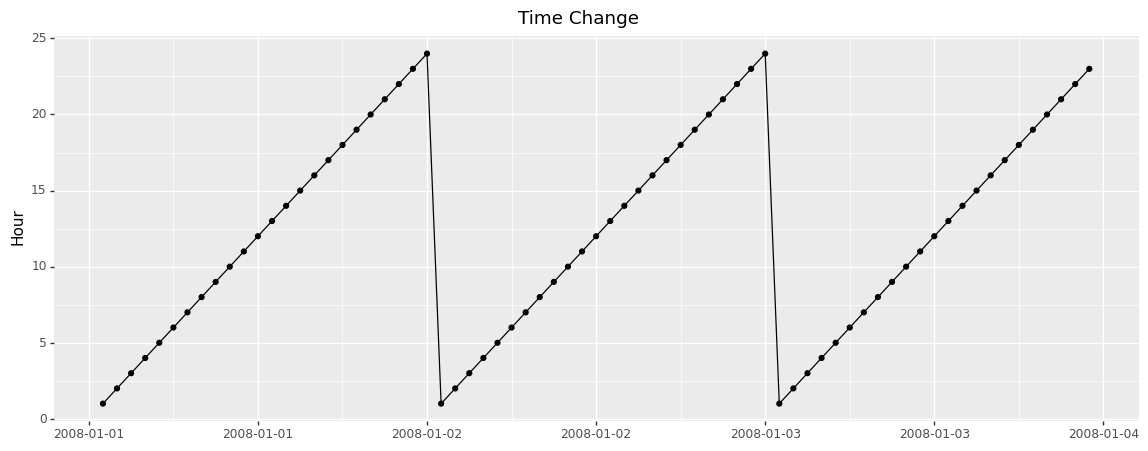

<ggplot: (8777642587853)>

In [5]:
(ggplot(df1, aes(df1.index,'Hour')) + geom_point() + geom_line() 
+ labs(y = "Hour", title ="Time Change") 
+ theme(figure_size=(14,5))
)

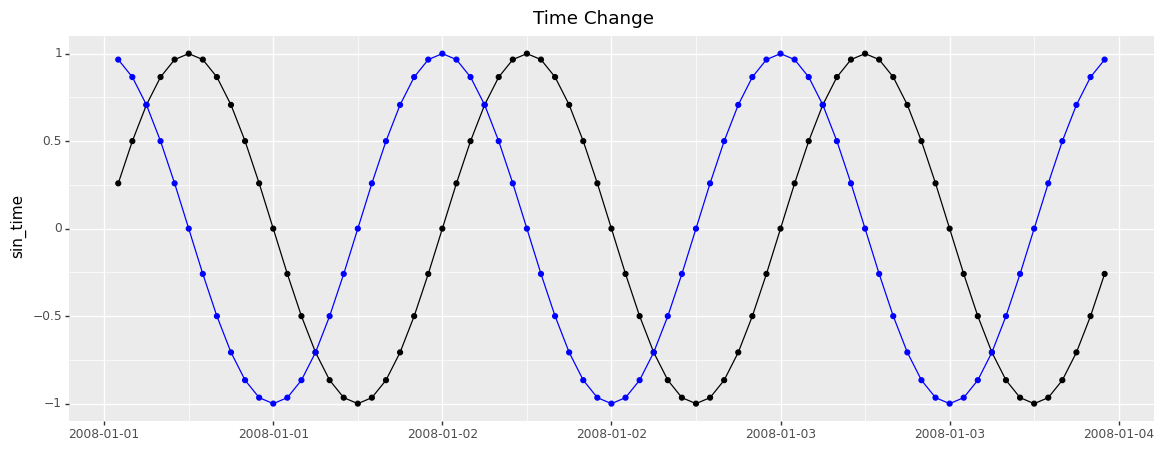

<ggplot: (8777642596229)>

In [6]:
(ggplot(df1, aes(df1.index,'sin_time')) + geom_point() + geom_line() 
+ geom_point(aes(df1.index, 'cos_time'), color='blue') + geom_line(aes(df1.index, 'cos_time'), color='blue') 
+ labs(y = "sin_time", title ="Time Change") 
+ theme(figure_size=(14,5))
)

/Users/kyra/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 8784 rows containing missing values.
/Users/kyra/opt/anaconda3/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 13 rows containing missing values.


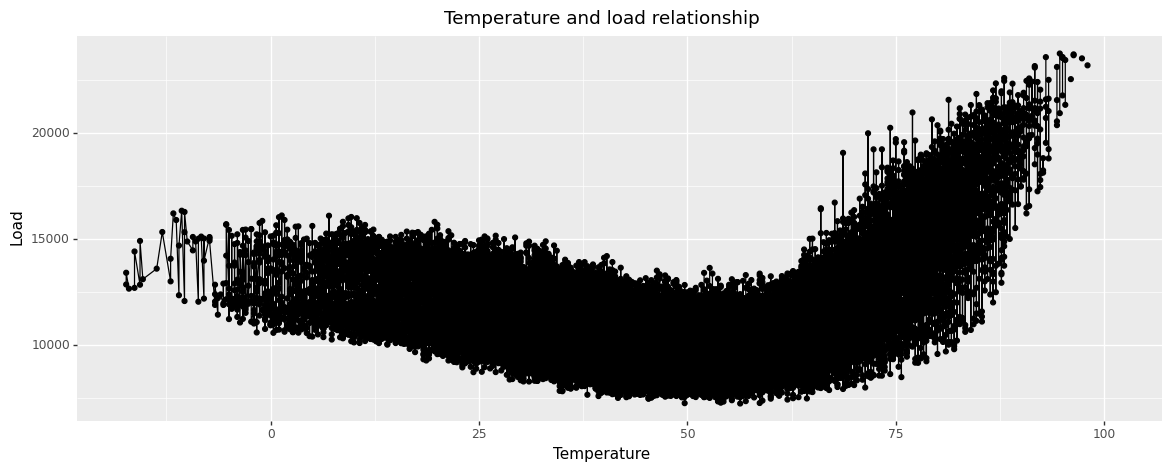

<ggplot: (8777638954801)>

In [7]:
(ggplot(df, aes('Temperature','Load')) + geom_point() + geom_line() 
+ labs(y = "Load", title ="Temperature and load relationship") 
+ theme(figure_size=(14,5))
)

Temperature does not have linear relationship with the Load. They have quadric relationship. (High load in summer and winter) # We can show this.<br>
Thus, we will use temperature square variable. <br>  

In [8]:
# adding variable temp_squared
df['temp_sq'] = df['Temperature'] * df['Temperature']

/Users/kyra/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 8784 rows containing missing values.
/Users/kyra/opt/anaconda3/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 13 rows containing missing values.


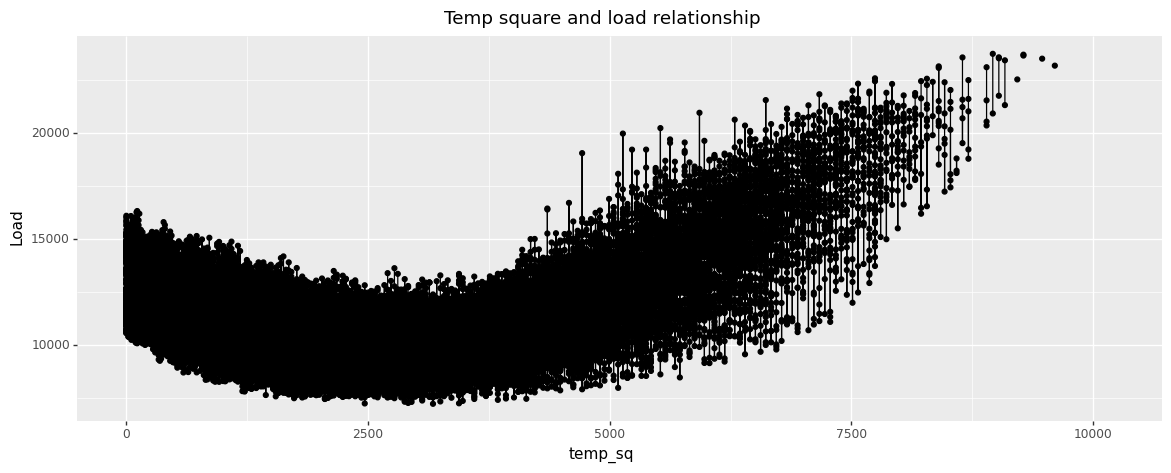

<ggplot: (8777623350628)>

In [9]:
(ggplot(df, aes('temp_sq','Load')) + geom_point() + geom_line() 
+ labs(y = "Load", title ="Temp square and load relationship") 
+ theme(figure_size=(14,5))
)

In [10]:
train = df.loc[df.index <= '2012-01-01 00:00:00']

In [11]:
train.describe()

,Hour,Temperature,Load,year,month,day,week,dayofweek,weekofyear,sin_time,cos_time,temp_sq
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,3.506400e+04,3.506400e+04,35064.000000
mean,12.500000,49.371563,11639.447525,2009.499087,6.522930,15.729637,26.628422,3.000143,26.628422,-7.400602e-17,-7.398954e-17,2864.298904
std,6.922285,20.658167,2317.204003,1.118407,3.448752,8.800218,15.064648,1.998352,15.064648,7.071169e-01,7.071169e-01,2003.159246
min,1.000000,-17.330000,7223.000000,2008.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-1.000000e+00,-1.000000e+00,0.000000
25%,6.750000,33.330000,9962.000000,2008.000000,4.000000,8.000000,14.000000,1.000000,14.000000,-7.071068e-01,-7.071068e-01,1110.888900
50%,12.500000,50.330000,11450.000000,2009.000000,7.000000,16.000000,27.000000,3.000000,27.000000,-6.123234e-17,-6.123234e-17,2533.108900
75%,18.250000,66.330000,12811.000000,2010.000000,10.000000,23.000000,40.000000,5.000000,40.000000,7.071068e-01,7.071068e-01,4399.668900
max,24.000000,98.000000,23753.000000,2012.000000,12.000000,31.000000,53.000000,6.000000,53.000000,1.000000e+00,1.000000e+00,9604.000000


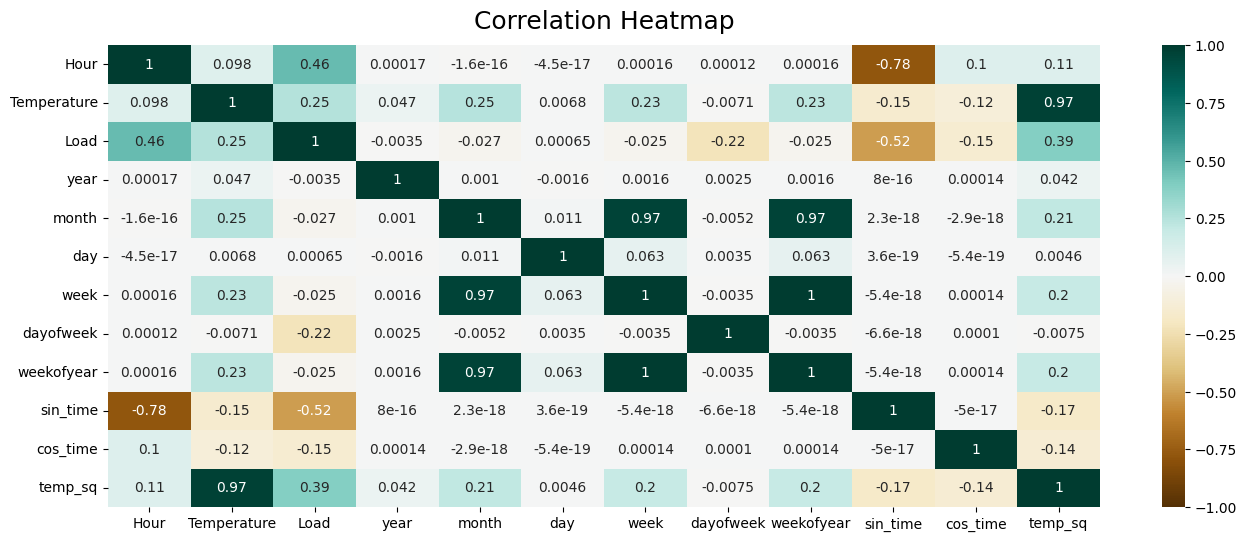

In [12]:
#Detecting Multicollinearity with VIF. Eleminating independent variables that are highly correlated with one another.
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# to drop unused independent variables and Independent Variables that are highly correlated to another independent variables based on VIF above - 'Date','Hour','Temperature'
train.drop(['Date', 'Hour','Temperature','week','month'], axis=1, inplace=True)

<ipython-input-13-564d28522c36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


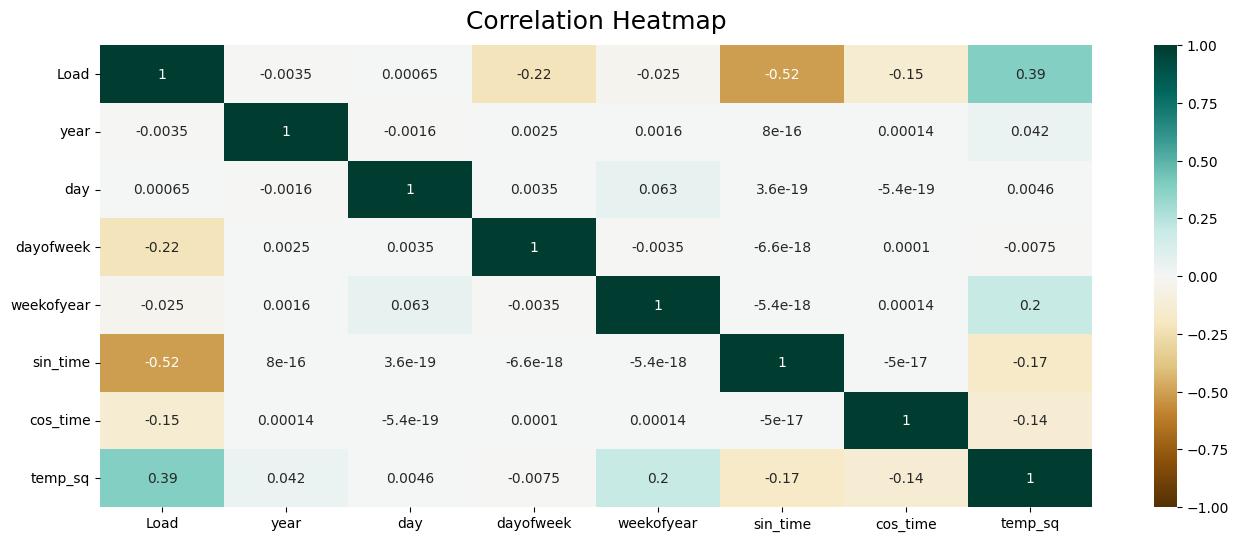

In [14]:
#Check VIF again
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
train.head(5)

,Load,year,day,dayofweek,weekofyear,sin_time,cos_time,temp_sq
DateTime,,,,,,,,
2008-01-01 01:00:00,10737.0,2008,1,1,1,0.258819,0.965926,625.0
2008-01-01 02:00:00,10348.0,2008,1,1,1,0.500000,0.866025,576.0
2008-01-01 03:00:00,9997.0,2008,1,1,1,0.707107,0.707107,529.0
2008-01-01 04:00:00,9760.0,2008,1,1,1,0.866025,0.500000,529.0
2008-01-01 05:00:00,9624.0,2008,1,1,1,0.965926,0.258819,529.0


**Pycaret: First we use Pycaret to determine some of the best fitting ML Models**

In [16]:
# conda create -n sklearn-env -c conda-forge scikit-learn-y

In [17]:
# conda activate sklearn-env

In [18]:
from pycaret.regression import *
exp_reg101 = setup(data = train, target = 'Load', session_id=123) 

,Description,Value
0,Session id,123
1,Target,Load
2,Target type,Regression
3,Data shape,"(35064, 8)"
4,Train data shape,"(24544, 8)"
5,Test data shape,"(10520, 8)"
6,Numeric features,7
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [19]:
best = compare_models(sort='mape')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,260.4781,154663.8836,392.9610,0.9706,0.0313,0.0219,0.5060
xgboost,Extreme Gradient Boosting,270.9222,166777.2922,407.9880,0.9683,0.0325,0.0227,0.3570
rf,Random Forest Regressor,310.2502,245875.9499,495.5642,0.9533,0.0396,0.0260,0.6010
et,Extra Trees Regressor,314.7657,247629.3515,497.2503,0.9529,0.0400,0.0265,0.4840
lightgbm,Light Gradient Boosting Machine,323.8845,225002.0069,474.0808,0.9572,0.0380,0.0273,0.0550
dt,Decision Tree Regressor,425.3526,505500.1429,710.5796,0.9039,0.0566,0.0356,0.0270
gbr,Gradient Boosting Regressor,461.4949,441524.0200,664.2600,0.9160,0.0534,0.0390,0.3000
ada,AdaBoost Regressor,926.5933,1283353.5271,1132.5770,0.7558,0.1010,0.0845,0.3110
knn,K Neighbors Regressor,1181.5136,2153931.7000,1467.5697,0.5902,0.1276,0.1057,0.0120
huber,Huber Regressor,1367.5681,3166268.7207,1779.1496,0.3982,0.1443,0.1162,0.0260


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [20]:
best

In [21]:
M1 = create_model('catboost') 

# catboost model
# K-fold method : 10 fold Cross Validation
# Average MAPE : 2.19% 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,258.5549,152077.5624,389.9712,0.9721,0.0311,0.0217
1,256.0226,155362.4899,394.1605,0.9700,0.0313,0.0216
2,254.4299,140861.6756,375.3154,0.9723,0.0302,0.0214
3,267.4955,165062.0479,406.2783,0.9697,0.0320,0.0224
4,248.5508,134218.4508,366.3584,0.9737,0.0292,0.0209
5,265.3703,160956.1657,401.1934,0.9707,0.0314,0.0221
6,261.9094,150188.7141,387.5419,0.9714,0.0319,0.0222
7,264.6709,182025.4888,426.6445,0.9650,0.0333,0.0221
8,263.4958,151237.4562,388.8926,0.9705,0.0309,0.0220


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
print(M1)

In [23]:
M2 = create_model('xgboost') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,267.2260,158344.3906,397.9251,0.9710,0.0317,0.0224
1,276.5962,175699.1875,419.1649,0.9660,0.0332,0.0233
2,260.9842,144174.6719,379.7034,0.9716,0.0308,0.0220
3,275.0645,180274.5625,424.5875,0.9669,0.0334,0.0231
4,257.0153,149390.0000,386.5100,0.9708,0.0308,0.0217
5,270.6146,166530.0000,408.0809,0.9697,0.0318,0.0226
6,273.8376,163606.8750,404.4835,0.9689,0.0331,0.0231
7,274.8260,192818.5625,439.1111,0.9630,0.0346,0.0230
8,268.0875,155792.2188,394.7052,0.9696,0.0314,0.0224


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
M3 = create_model('rf') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,304.3568,232346.1997,482.0230,0.9574,0.0381,0.0254
1,314.0053,268816.8022,518.4755,0.9480,0.0408,0.0264
2,303.6261,229397.4753,478.9546,0.9549,0.0389,0.0255
3,323.8037,277684.0951,526.9574,0.9491,0.0417,0.0271
4,295.8277,219596.8739,468.6116,0.9570,0.0375,0.0248
5,315.0929,243323.3140,493.2781,0.9558,0.0389,0.0262
6,316.5639,241309.3085,491.2324,0.9541,0.0403,0.0268
7,309.0024,259442.6806,509.3552,0.9502,0.0410,0.0261
8,315.4116,242702.6400,492.6486,0.9527,0.0393,0.0263


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
M4 = create_model('et') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,313.1503,243867.8090,493.8297,0.9553,0.0394,0.0263
1,314.0414,264057.4864,513.8652,0.9489,0.0411,0.0266
2,305.8332,225181.2100,474.5326,0.9557,0.0388,0.0258
3,327.1253,283213.1902,532.1778,0.9481,0.0422,0.0275
4,296.3341,212900.9284,461.4119,0.9583,0.0373,0.0251
5,321.4571,242426.3516,492.3681,0.9559,0.0389,0.0268
6,317.5193,241590.3317,491.5184,0.9541,0.0405,0.0270
7,310.4997,260071.5175,509.9721,0.9500,0.0412,0.0263
8,320.4210,242704.9841,492.6510,0.9527,0.0397,0.0269


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Plotting the models


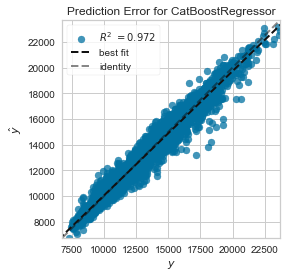

In [26]:
#plot for Catboost
plot_model(M1, plot='error')

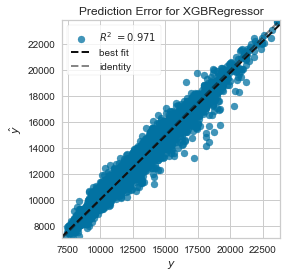

In [27]:
#plot for Xgboost
plot_model(M2, plot='error')

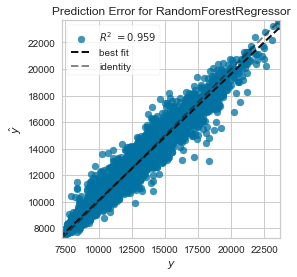

In [28]:
#Random Forest
plot_model(M3, plot='error')

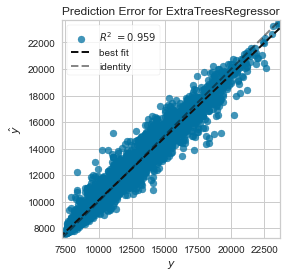

In [29]:
#extra trees
plot_model(M4, plot='error')

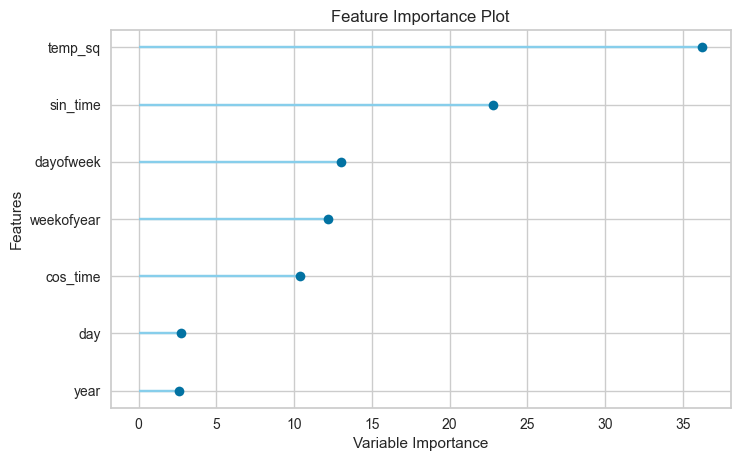

In [30]:
#Feature importance for our optimal model - Catboost
plot_model(M1, plot='feature')

In [31]:
evaluate_model(M1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [32]:
predict_model(M1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,263.6117,158315.8222,397.8892,0.9718,0.0311,0.0218


,year,day,dayofweek,weekofyear,sin_time,cos_time,temp_sq,Load,prediction_label
24544,2011.0,21.0,3.0,16.0,-7.071068e-01,7.071068e-01,1791.828857,11309.0,11335.907727
24545,2010.0,25.0,0.0,43.0,-9.659258e-01,2.588190e-01,4533.329102,11989.0,12123.678132
24546,2011.0,24.0,5.0,38.0,-8.660254e-01,5.000000e-01,2738.428955,9617.0,9786.755163
24547,2008.0,8.0,4.0,32.0,9.659258e-01,-2.588190e-01,4053.868896,10458.0,10253.346687
24548,2008.0,29.0,6.0,26.0,-2.449294e-16,1.000000e+00,4312.548828,11338.0,12141.651188
...,...,...,...,...,...,...,...,...,...
35059,2010.0,27.0,6.0,25.0,-8.660254e-01,5.000000e-01,6400.000000,16220.0,15912.745559
35060,2008.0,5.0,2.0,10.0,-2.588190e-01,9.659258e-01,1045.228882,12736.0,12786.669061
35061,2009.0,1.0,2.0,14.0,1.000000e+00,6.123234e-17,1419.028931,9197.0,8941.054673
35062,2011.0,17.0,5.0,50.0,9.659258e-01,2.588190e-01,802.588928,9682.0,9741.258075


Finalize the model

In [33]:
final_M1 = finalize_model(M1)

In [34]:
print(final_M1)

Pipeline(memory=Memory(location=/var/folders/qz/67xcy6s15tzdb9q9r70t7tc80000gn/T/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['year', 'day', 'dayofweek',
                                             'weekofyear', 'sin_time',
                                             'cos_time', 'temp_sq'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strategy='constant'))),
                ('low_variance',
                 TransformerWrapper(exclude=[],
                                    transformer=VarianceThreshold(threshold=0))),
                ('actual_estimator',
                 <catboost.core.CatBoostRegressor object at 0x7fbb46cd97f0>)])


Predict values by using our final model


In [35]:
predict_model(final_M1)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,233.9410,119654.5297,345.9112,0.9787,0.0275,0.0196


,year,day,dayofweek,weekofyear,sin_time,cos_time,temp_sq,Load,prediction_label
24544,2011.0,21.0,3.0,16.0,-7.071068e-01,7.071068e-01,1791.828857,11309.0,11387.130030
24545,2010.0,25.0,0.0,43.0,-9.659258e-01,2.588190e-01,4533.329102,11989.0,11969.760031
24546,2011.0,24.0,5.0,38.0,-8.660254e-01,5.000000e-01,2738.428955,9617.0,9926.945202
24547,2008.0,8.0,4.0,32.0,9.659258e-01,-2.588190e-01,4053.868896,10458.0,10153.197804
24548,2008.0,29.0,6.0,26.0,-2.449294e-16,1.000000e+00,4312.548828,11338.0,12047.211265
...,...,...,...,...,...,...,...,...,...
35059,2010.0,27.0,6.0,25.0,-8.660254e-01,5.000000e-01,6400.000000,16220.0,16096.169738
35060,2008.0,5.0,2.0,10.0,-2.588190e-01,9.659258e-01,1045.228882,12736.0,12763.012700
35061,2009.0,1.0,2.0,14.0,1.000000e+00,6.123234e-17,1419.028931,9197.0,8947.702437
35062,2011.0,17.0,5.0,50.0,9.659258e-01,2.588190e-01,802.588928,9682.0,9761.632691


In [36]:
X_test = df.drop(['Date', 'Hour', 'Load','Temperature','week','month'], axis=1)

In [37]:
prediction = predict_model(final_M1, data=X_test)
pred1 = pd.DataFrame(prediction, columns=['prediction_label'])
pred1.to_csv('cat_prediction_pycaret.csv')

**Further Exploration of best 4 models from Pycaret**

In [38]:
# Set variables for ML models

y = train['Load'] # dependent variable
X = train.drop(['Load'], axis=1) # independent variables 

In [39]:
# Use the train_test_split function to split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [40]:
#to avoid overfitting problem with Tree model, we need pretuning.
#To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [288]:
#ML Model 1: Random Forest
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/kyra/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [289]:
# best hyperparameters based on random grid search
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [290]:
# evaluate and compare the base model to the best random search model
def evaluate(model, test_features, test_labels):
    print("out-of-sample R squared: ", model.score(test_features, test_labels))
# evaluate base Random Forest Model
base_rf_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_rf_model.fit(X_train, y_train)
base_rf_accuracy = evaluate(base_rf_model, X_test, y_test)

out-of-sample R squared:  0.9511909788654144


In [291]:
# evaluate the best random search model
best_rf_random = rf_random.best_estimator_
best_rf_accuracy = evaluate(best_rf_random, X_test, y_test)
# Comparing the results, we can see the best random search model have better Accuracy and out of sample R-squared - so we will use the best random search model

out-of-sample R squared:  0.9667986818293504


In [292]:
#ML Model 2: Catboost
import catboost as ctb

In [293]:
# Catboost
# Fit model - Base Model
base_cat = ctb.CatBoostRegressor(random_state=42)
base_cat.fit(X_train,y_train)

Learning rate set to 0.068994
0:	learn: 2198.3338137	total: 5.45ms	remaining: 5.44s
1:	learn: 2090.5654080	total: 7.83ms	remaining: 3.91s
2:	learn: 1990.7896068	total: 10.3ms	remaining: 3.44s
3:	learn: 1903.6307001	total: 12.4ms	remaining: 3.09s
4:	learn: 1817.4090542	total: 15ms	remaining: 2.98s
5:	learn: 1741.9670512	total: 18.9ms	remaining: 3.13s
6:	learn: 1672.7070274	total: 21.5ms	remaining: 3.05s
7:	learn: 1605.0993007	total: 25.6ms	remaining: 3.17s
8:	learn: 1540.8182576	total: 28.5ms	remaining: 3.13s
9:	learn: 1486.5352428	total: 33.4ms	remaining: 3.31s
10:	learn: 1433.0917678	total: 35.9ms	remaining: 3.23s
11:	learn: 1386.3385419	total: 41.8ms	remaining: 3.44s
12:	learn: 1339.9500143	total: 44ms	remaining: 3.34s
13:	learn: 1297.5152890	total: 46.9ms	remaining: 3.31s
14:	learn: 1259.6288942	total: 50ms	remaining: 3.28s
15:	learn: 1223.5238311	total: 52.9ms	remaining: 3.25s
16:	learn: 1191.3908009	total: 55.3ms	remaining: 3.2s
17:	learn: 1160.0422992	total: 59.8ms	remaining: 3.2

In [294]:
base_cat_accuracy = evaluate(base_cat, X_test, y_test)

out-of-sample R squared:  0.9722629556270126


In [295]:
#Use GridSearchCV to find the best hyperparameters 
from sklearn.model_selection import GridSearchCV
model = ctb.CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)

0:	learn: 2131.8572221	total: 11.8ms	remaining: 1.17s
1:	learn: 1970.6122769	total: 31.2ms	remaining: 1.53s
2:	learn: 1827.6922440	total: 40.3ms	remaining: 1.3s
3:	learn: 1699.3769052	total: 44.4ms	remaining: 1.06s
4:	learn: 1585.9719722	total: 56.2ms	remaining: 1.07s
5:	learn: 1483.3198757	total: 63ms	remaining: 987ms
6:	learn: 1387.5773344	total: 77.1ms	remaining: 1.02s
7:	learn: 1309.4121757	total: 83.6ms	remaining: 962ms
8:	learn: 1236.7087076	total: 91.8ms	remaining: 928ms
9:	learn: 1169.5649682	total: 97.3ms	remaining: 876ms
10:	learn: 1108.0466797	total: 104ms	remaining: 838ms
11:	learn: 1050.3758298	total: 110ms	remaining: 809ms
12:	learn: 1000.3479350	total: 126ms	remaining: 846ms
13:	learn: 956.7370640	total: 133ms	remaining: 818ms
14:	learn: 918.7114100	total: 139ms	remaining: 790ms
15:	learn: 883.8798904	total: 145ms	remaining: 763ms
16:	learn: 855.0820926	total: 152ms	remaining: 740ms
17:	learn: 825.1997146	total: 158ms	remaining: 719ms
18:	learn: 799.6525989	total: 186ms	

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc492c4b5e0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [296]:
grid.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 0.1}

In [297]:
# xgboost: evaluate the best random search model
best_cat = grid.best_estimator_
best_cat_accuracy = evaluate(best_cat, X_test, y_test)
# the results using the tuned model is worse than using base model. So we would use base model instead.

out-of-sample R squared:  0.9586591127336196


In [298]:
# ML Model 3: XGBoost model
# Base Model

base_xg = XGBRegressor(random_state=1, n_estimators = 400)
base_xg.fit(X_train, y_train) # fit the model
pred = base_xg.predict(X_test) # make prediction
base_xg_accuracy = evaluate(base_xg, X_test, y_test)

out-of-sample R squared:  0.979882684113913


In [299]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xg = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xg_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/kyra/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[00:03:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [300]:
# # best hyperparameters based on random grid search
xg_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [301]:
# xgboost: evaluate the best random search model
best_xg_random = xg_random.best_estimator_
best_xg_accuracy = evaluate(best_xg_random, X_test, y_test)
# the results using the best random model is better than only using base model. So we would use the tuned hyperparameters.

out-of-sample R squared:  0.9826682203788466


In [302]:
#ML Model 4: extra Forest
# evaluate base Random Forest Model
base_et_model = ExtraTreesRegressor(n_estimators = 10, random_state = 42)
base_et_model.fit(X_train, y_train)
base__et_accuracy = evaluate(base_et_model, X_test, y_test)

out-of-sample R squared:  0.9512364951276095


In [303]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
et = ExtraTreesRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
et_random = RandomizedSearchCV(estimator = et, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
et_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/kyra/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
/Users/kyra/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


RandomizedSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [304]:
# best hyperparameters based on random grid search
et_random.best_params_


{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [305]:
# evaluate the best random search model
best_et_random = et_random.best_estimator_
best_et_accuracy = evaluate(best_et_random, X_test, y_test)
# the results using the best random model is better than only using base model. So we would use the tuned hyperparameters.

out-of-sample R squared:  0.9584687283704362


**Conclusion:** <br>
XGBoost, Catboost and Random Forest models provide the best three out-of-sample R squared value. <br>
So, we will choose these three models to predict the Electricity demand of testing periods. <br>
We will compare the final MAPE using the Excel file and choose our best ML model.

In [306]:
# Final XGBoost Model with full training data 
final_xg_model = best_xg_random
# final_xg_model = base_xg
final_xg_model.fit(X, y)

[00:11:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=False,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, max_features='sqrt',
             min_child_weight=1, min_samples_leaf=4, min_samples_split=5,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [307]:
# Final Random Forest Model with full training data 
final_rf_model = best_rf_random
# final_rf_model = base_rf_model
final_rf_model.fit(X, y)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

In [308]:
# Final Catboost Model with full training data 
# final_cat_model = best_cat
final_cat_model = base_cat
final_cat_model.fit(X, y)

Learning rate set to 0.073517
0:	learn: 2191.6800565	total: 12.5ms	remaining: 12.5s
1:	learn: 2076.3042688	total: 17.3ms	remaining: 8.63s
2:	learn: 1972.7998288	total: 20.3ms	remaining: 6.75s
3:	learn: 1877.8459930	total: 22.7ms	remaining: 5.66s
4:	learn: 1790.6296876	total: 25.6ms	remaining: 5.1s
5:	learn: 1708.3017324	total: 28.3ms	remaining: 4.68s
6:	learn: 1634.0941439	total: 30.9ms	remaining: 4.39s
7:	learn: 1565.7613392	total: 33.2ms	remaining: 4.12s
8:	learn: 1504.7555112	total: 37ms	remaining: 4.07s
9:	learn: 1444.8211484	total: 39.2ms	remaining: 3.88s
10:	learn: 1387.7464005	total: 42.3ms	remaining: 3.81s
11:	learn: 1340.5200975	total: 45.5ms	remaining: 3.75s
12:	learn: 1296.2865028	total: 48.3ms	remaining: 3.67s
13:	learn: 1255.6309769	total: 51.4ms	remaining: 3.62s
14:	learn: 1217.3000213	total: 54.1ms	remaining: 3.55s
15:	learn: 1181.7482265	total: 56.8ms	remaining: 3.49s
16:	learn: 1145.3428724	total: 59.5ms	remaining: 3.44s
17:	learn: 1114.7404374	total: 61.8ms	remaining:

In [309]:
# Make dataframe of independent variables for entire data period 

X_test = df.drop(['Date', 'Hour', 'Load','Temperature','week','month'], axis=1)
X_test

,year,day,dayofweek,weekofyear,sin_time,cos_time,temp_sq
DateTime,,,,,,,
2008-01-01 01:00:00,2008,1,1,1,2.588190e-01,0.965926,625.0000
2008-01-01 02:00:00,2008,1,1,1,5.000000e-01,0.866025,576.0000
2008-01-01 03:00:00,2008,1,1,1,7.071068e-01,0.707107,529.0000
2008-01-01 04:00:00,2008,1,1,1,8.660254e-01,0.500000,529.0000
2008-01-01 05:00:00,2008,1,1,1,9.659258e-01,0.258819,529.0000
...,...,...,...,...,...,...,...
2012-12-31 20:00:00,2012,31,0,1,-8.660254e-01,0.500000,498.6289
2012-12-31 21:00:00,2012,31,0,1,-7.071068e-01,0.707107,427.2489
2012-12-31 22:00:00,2012,31,0,1,-5.000000e-01,0.866025,386.9089


In [310]:
prediction = final_xg_model.predict(X_test) 
print(prediction)
print(len(prediction))

pred = pd.DataFrame(prediction, columns=['Load'])
pred.to_csv('XGBoost_prediction_tuned.csv')

[10727.93  10331.54  10011.227 ... 14025.127 13096.975 12007.642]
43848


In [311]:
prediction1 = final_rf_model.predict(X_test) 
print(prediction1)
print(len(prediction1))

pred1 = pd.DataFrame(prediction1, columns=['Load'])
pred1.to_csv('RF_prediction_tuned.csv')

[10737.     10348.      9997.     ... 13659.4275 13136.72   12116.305 ]
43848


In [312]:
prediction2 = final_cat_model.predict(X_test) 
print(prediction2)
print(len(prediction2))

pred = pd.DataFrame(prediction2, columns=['Load'])
pred.to_csv('cat_prediction_tuned.csv')

[10382.31543841  9840.21990904  9613.93246412 ... 13519.2435625
 12927.4572046  11748.3479453 ]
43848
